<a href="https://colab.research.google.com/github/MariaAltisheva/DataCon/blob/master/minitask_3_5_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Данные по задаче
**Материалы**

Данные, описание и безлайн -
https://drive.google.com/drive/folders/1mmZ-L-cDSX1v3e6mPsxg1chIpSqGMIM_?usp=sharing

Документация rdkit -
https://rdkit.org/docs/GettingStartedInPython.html

Документация sklearn -
https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

Документация shap -
https://shap.readthedocs.io/en/latest/

**Описание базы данных , где описаны показатели растворимости различных веществ в воде**

SMILES - Представление молекулы в текстовом формате smiles (https://chemicbook.com/2021/02/13/smiles-strings-explained-for-beginners-part-1.html).

Solubility - Растворимость вещества в воде.

MolLogP - десятичный логарифм коэффициента разделения.

MolMR -  Относительный молекулярный вес соединения.

HeavyAtomCount - Количество атомов не-водорода в молекуле.

NumRotatableBonds - Число поворотных связей в молекуле

NumValenceElectrons - Количество  валентных электронов в соединении.

NumAromaticRings - Количество ароматических колец в молекуле.

TPSA - Топологическая площадь поверхности полярных атомов в соединении.

LabuteASA - площадь поверхности молекулы, доступная для взаимодействия с
молекулами растворителя.

BertzCT - Индекс, предназначенный для количественной оценки “сложности”
молекул.

MolWt - Молекулярный вес соединения.



In [112]:
!pip install pandas
!pip install rdkit
!pip install seaborn
!pip install shap

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

# Задачи. Часть 1. Работа с данными

Просмотреть датасет на наличие выбросов и неверных данных
Разобраться в графиках из бейзлайна
Построить свои графики и выдвинуть по ним гипотезы
Отталкиваясь от этого, добавить некоторое количество новых дескрипторов при помощи rdkit (главное разобраться в коде, который это делает)

In [114]:
data = pd.read_csv("SolubilityDataset.csv")

In [115]:
data.info() # смотрим информацию по датасету

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SMILES               9982 non-null   object 
 1   Solubility           9897 non-null   float64
 2   MolLogP              9924 non-null   float64
 3   MolMR                9915 non-null   float64
 4   HeavyAtomCount       9959 non-null   float64
 5   NumRotatableBonds    9974 non-null   float64
 6   NumValenceElectrons  9917 non-null   float64
 7   NumAromaticRings     9936 non-null   float64
 8   TPSA                 9939 non-null   float64
 9   LabuteASA            9917 non-null   float64
 10  BertzCT              9945 non-null   float64
dtypes: float64(10), object(1)
memory usage: 858.0+ KB


Большинство данных представлены значениями с плавающей запятой. Это хороший показатель! Скорее всего нам не придется изменять типы данных. Видим, что количество заполненных ячеек не одинково. Значит нам нужно будет что-то либо удалять, либо заполнять какими-либо значениями.

In [116]:
data.describe() # описательные характеристики нашего датасета

,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
count,9897.000000,9924.000000,9915.000000,9959.000000,9974.000000,9917.000000,9936.000000,9939.000000,9917.000000,9945.000000
mean,-2.933150,2.105768,78.788567,20.680394,5.243207,110.108684,1.349831,72.007412,127.660684,633.041246
std,2.463204,6.404978,121.482849,31.995359,12.049642,161.179947,2.903197,111.540662,189.926788,1658.407352
min,-14.680503,-51.753311,-126.659494,-35.989931,-13.993534,-159.580874,-3.180648,-119.736167,-176.508845,-2017.692420
25%,-4.383890,0.589265,40.705000,11.000000,1.000000,58.000000,0.000000,26.300000,66.902973,164.945668
50%,-2.630000,1.951150,59.144700,15.000000,3.000000,82.000000,1.000000,51.800000,93.882886,356.889677
75%,-1.210000,3.465575,83.092200,21.000000,5.000000,114.000000,2.000000,81.500000,131.218031,620.450080
max,3.479977,78.808019,1560.034154,422.682696,155.074741,2206.490971,38.241124,1330.873755,2441.107013,22752.171111


In [117]:
data.isna().sum()

SMILES                  0
Solubility             85
MolLogP                58
MolMR                  67
HeavyAtomCount         23
NumRotatableBonds       8
NumValenceElectrons    65
NumAromaticRings       46
TPSA                   43
LabuteASA              65
BertzCT                37
dtype: int64

In [118]:
data.shape    # размеры нашего датасета

(9982, 11)

Принято решение заполнить NaN медианными значением.

In [119]:
data = data.fillna(data.mean())

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [120]:
data.head() # посмотрим, как выглядит датасет

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,10.0000,102.4454,23.0,17.0,142.0,0.0,0.00,158.520601,210.377334
1,O=C1Nc2cccc3cccc1c23,-3.254767,2.4055,51.9012,13.0,0.0,62.0,2.0,29.10,75.183563,511.229248
2,Clc1ccc(C=O)cc1,-2.177078,2.1525,36.8395,9.0,1.0,46.0,1.0,17.07,58.261134,6085.486839
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.1161,200.7106,53.0,10.0,264.0,6.0,120.72,323.755434,1964.648666
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,2.4854,119.0760,31.0,12.0,164.0,2.0,56.60,183.183268,769.899934


In [121]:
data = data[(data['MolMR'] > 200)] # ЧИСТИМ ВЫБРОСЫ ПО МАССЕ

Построим боксплоты и гистограммы для понимания, есть ли у нас выбросы и аномальные значения.

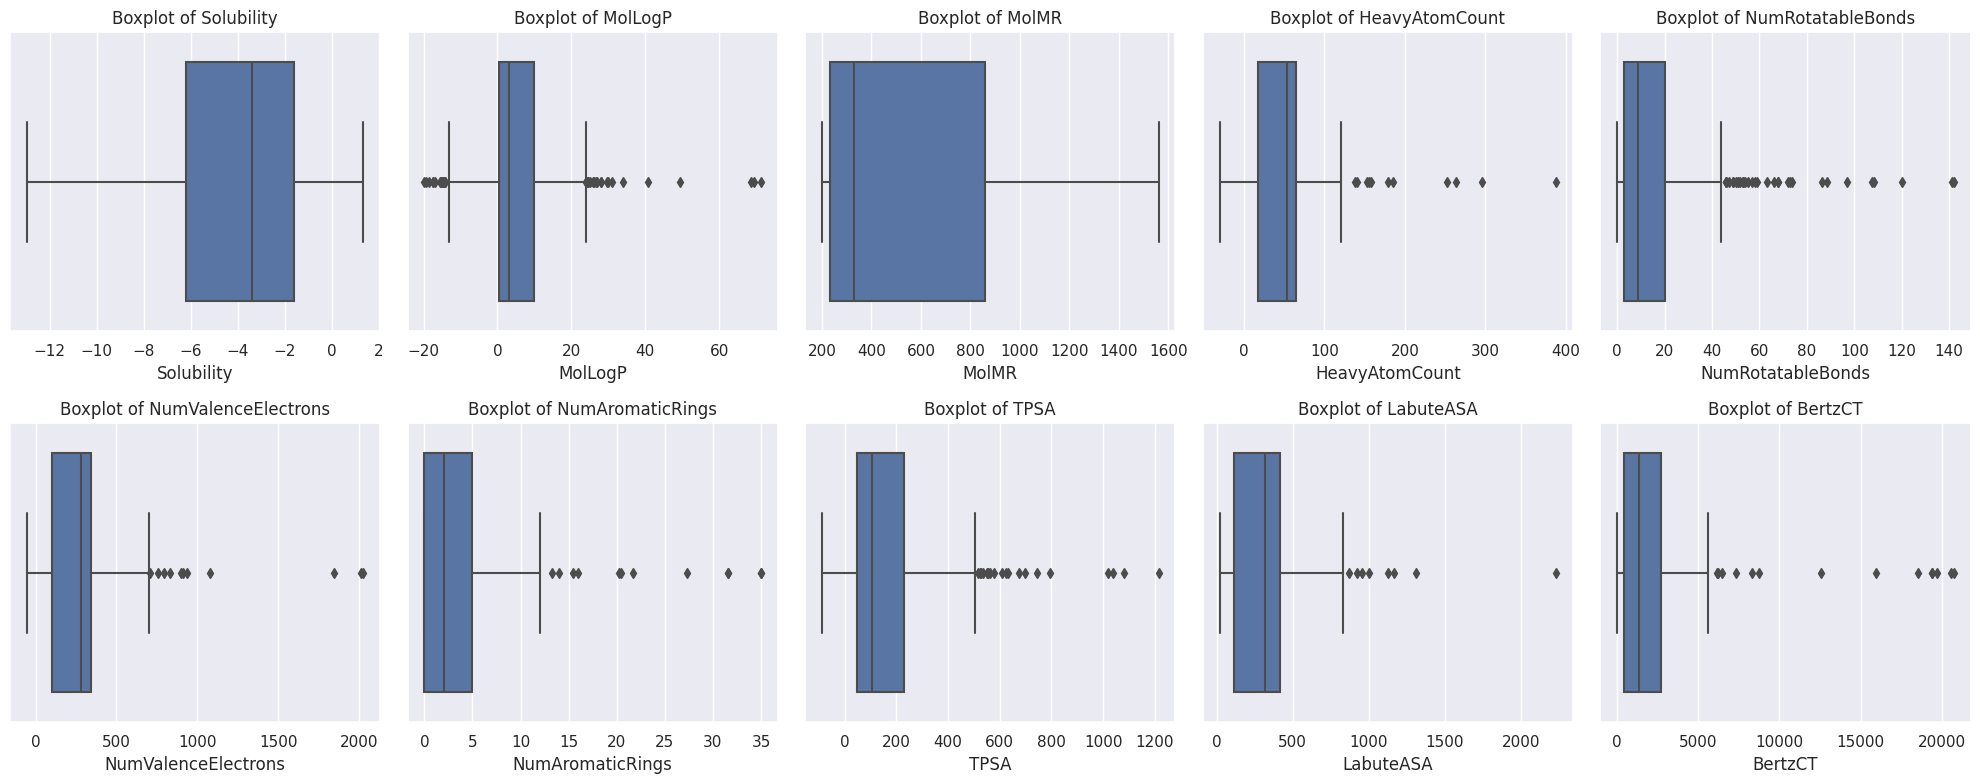

In [122]:
numerical_features = ['Solubility', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumRotatableBonds', 'NumValenceElectrons','NumAromaticRings', 'TPSA', 'LabuteASA', 'BertzCT']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=data, x=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

In [123]:
# проверяем, чтоб не удалить слишком много
data.shape


(321, 11)

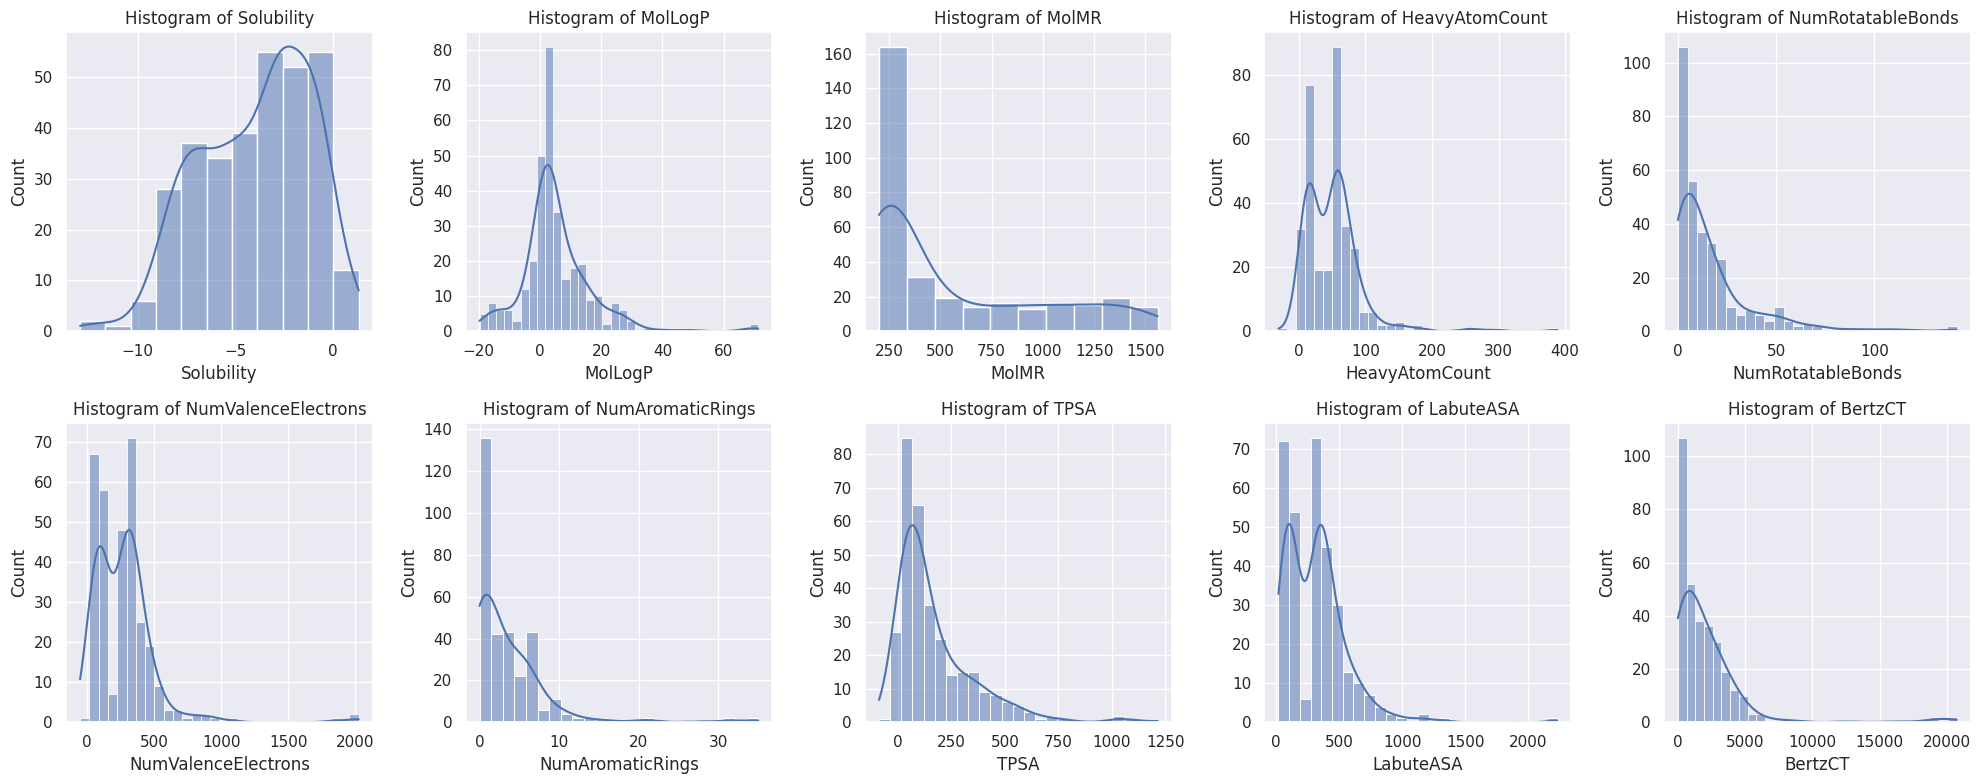

In [124]:
numerical_features = ['Solubility', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumRotatableBonds', 'NumValenceElectrons','NumAromaticRings', 'TPSA', 'LabuteASA', 'BertzCT']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data=data, x=feature, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

По данным графикам сейчас можно лишь сказать, что данные распределены неравномерно. Выбросов достаточно много.

Построим тепловую карту корреляции, а также общие графики.

In [125]:
#Изменение размера графика
sns.set(rc={'figure.figsize':(15,12)})

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

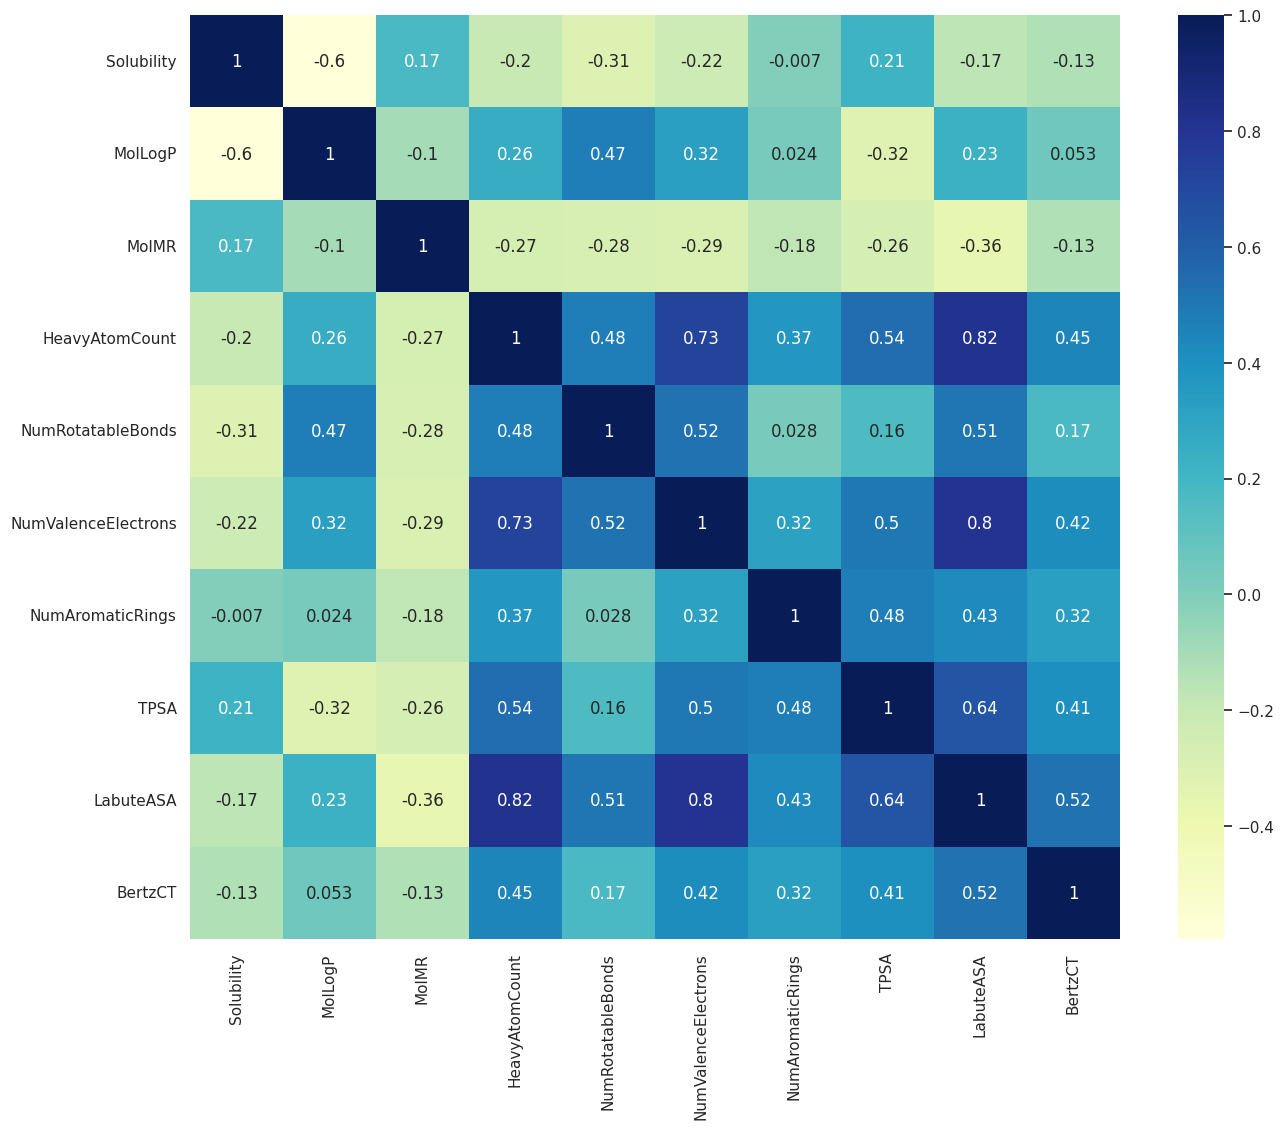

In [126]:
#Матрица корреляции между дескрипторами
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

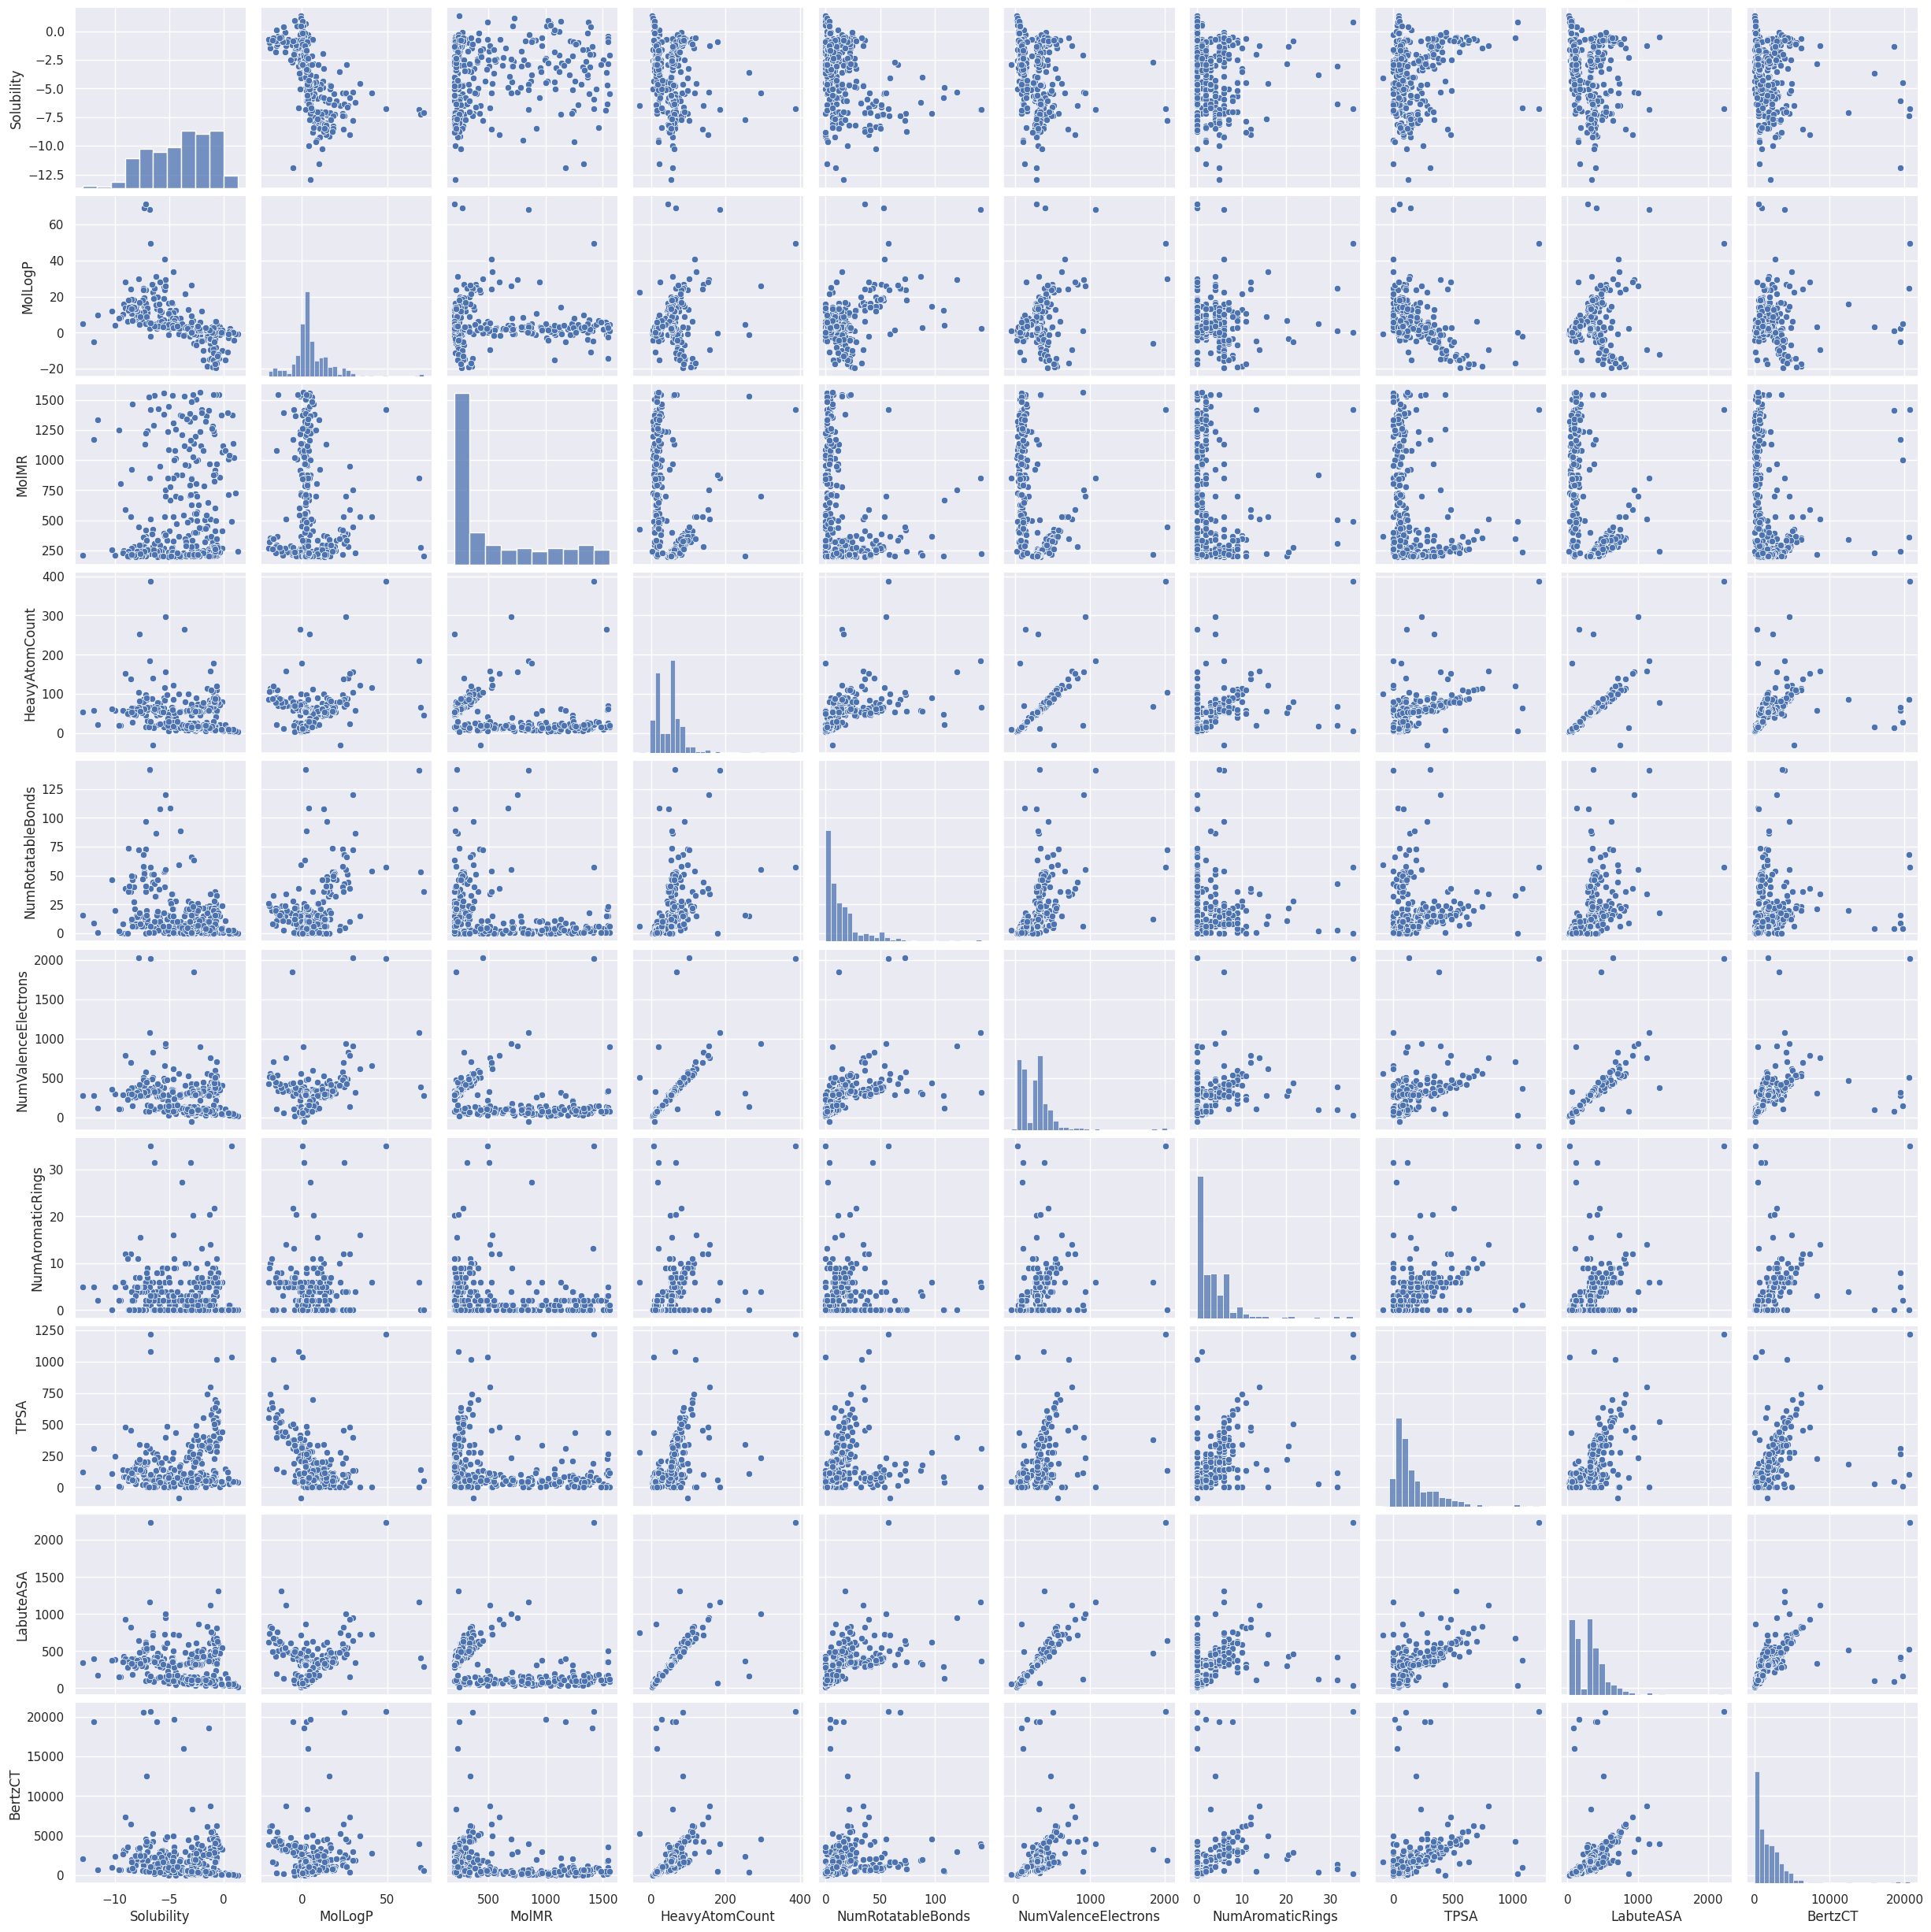

In [127]:
sns.pairplot(data.drop(columns = ["SMILES"], axis = 1))

По данным графикам можно сделать вывод о том, что существенно кореллируют такие показатели, как LabuteASA/eavyAtomCount, aleanceElectrons/LabuteASA, eavyAtomCount/NumValenceElectrons. При обучении модели стоит проигнорировать такие столбца, как LabuteASA и eavyAtomCount.

<Axes: >

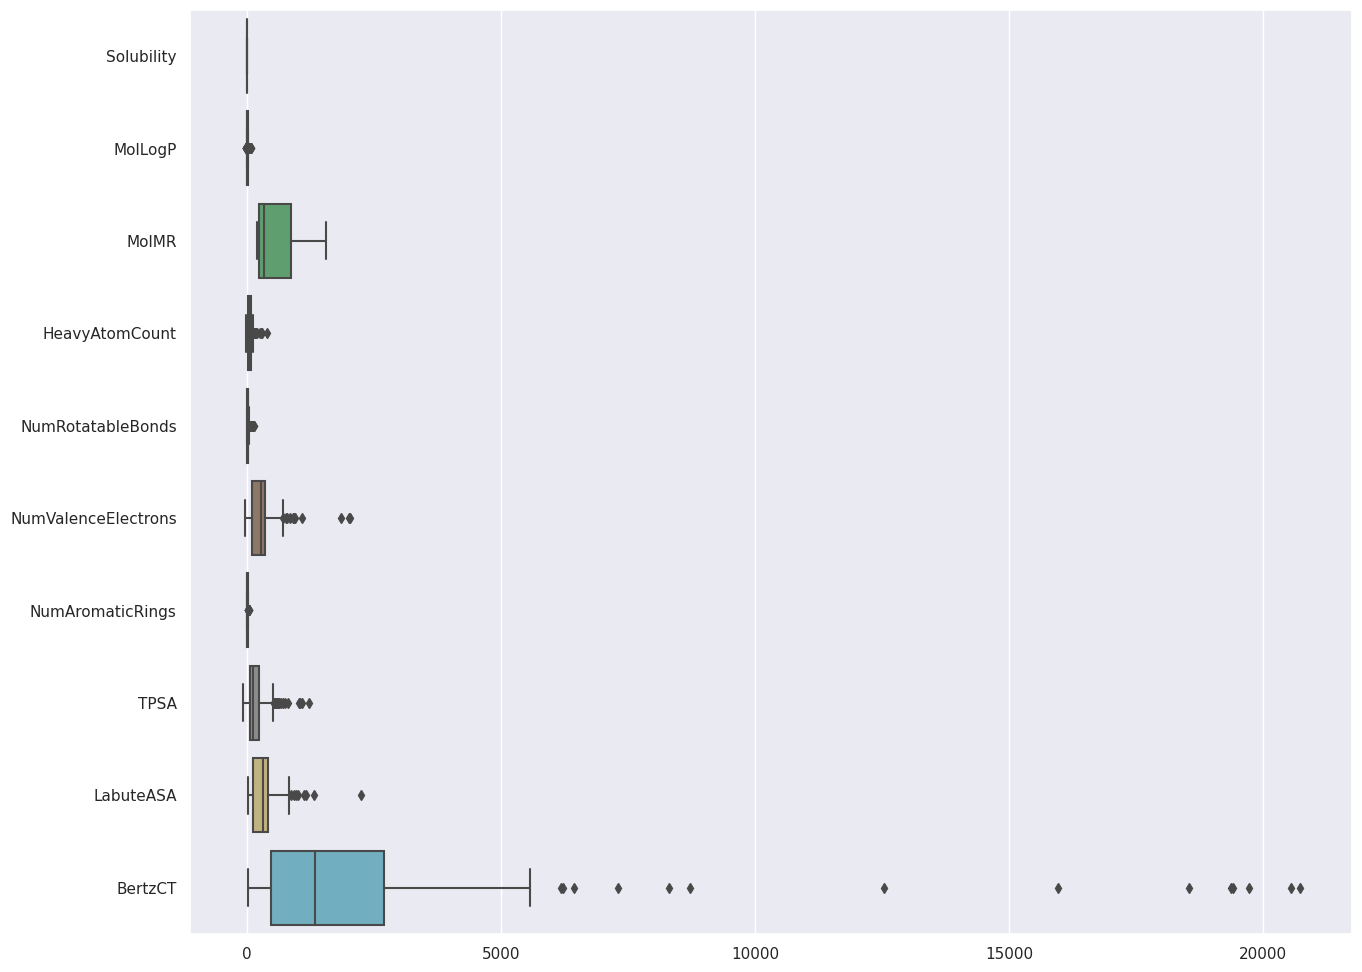

In [128]:
sns.boxplot(data=data, orient="h")

По колонке BertzCT принято решение удалить аномально большие значения.

<Axes: >

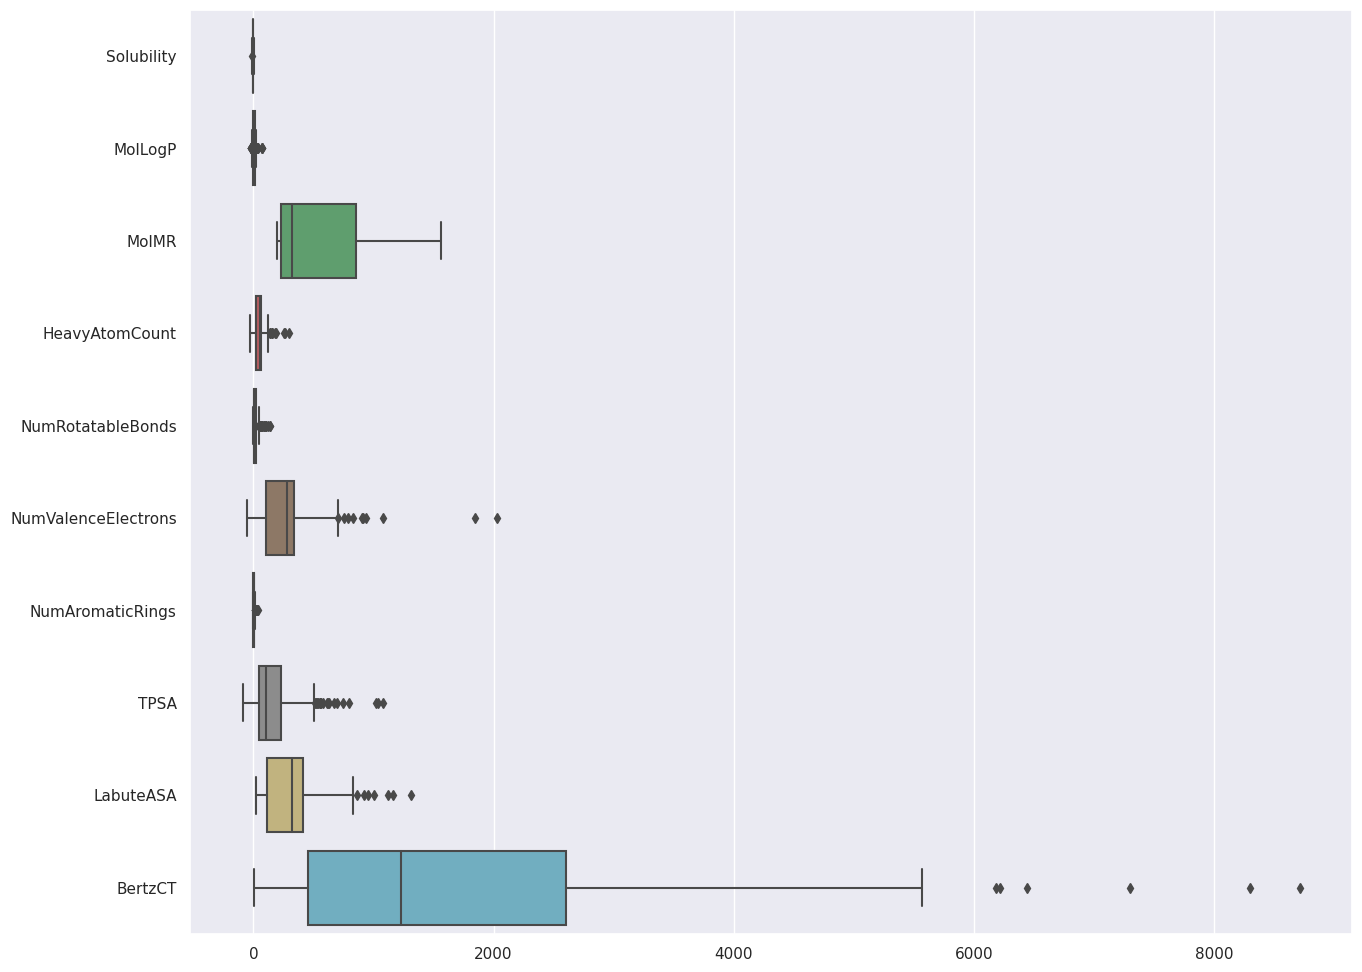

In [129]:
data = data[data.BertzCT<10000]
# проверяем выбросы
sns.boxplot(data=data, orient="h")

Пример добавление дескрипторов

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

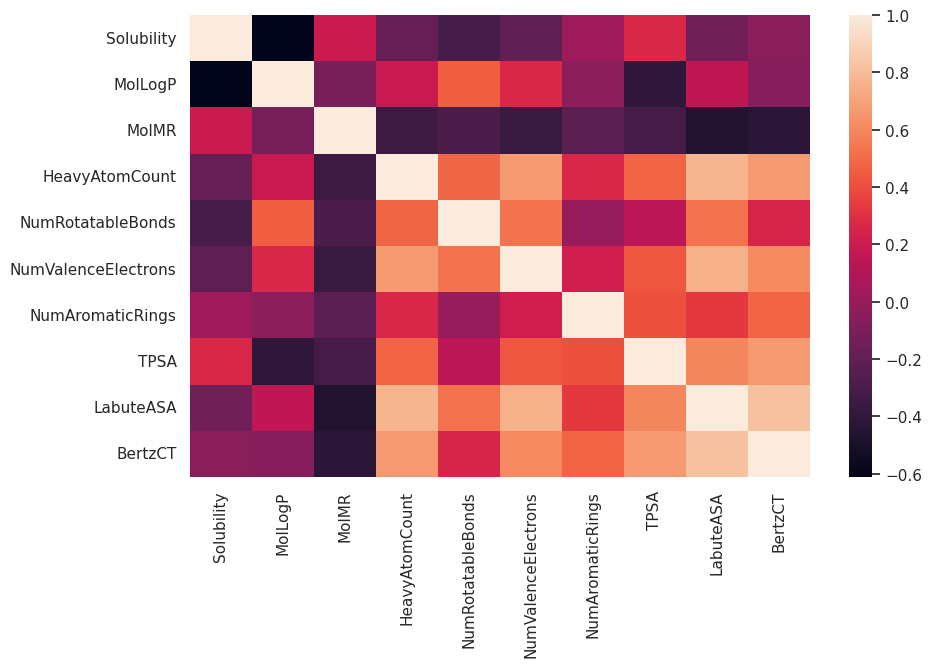

In [130]:
# Корреляционная матрица для числовых данных
data_corr=data.corr()

plt.figure(figsize = (10,6))
sns.heatmap(data_corr)

In [131]:
data["MolWt"] = pd.Series(np.array([Descriptors.MolWt(Chem.MolFromSmiles(i)) for i in data["SMILES"]]), index=data.index)

[09:37:10] WARNING: not removing hydrogen atom without neighbors


# Задачи. Часть 2. Построение моделей

Построить свои модели на основе базовых регрессий из scikit-learn
Минимум:

  Обойти бейзлайн и попробовать хотя бы 3-4 модели
отличные от него

  Попробовать поработать с изменением параметров моделей и изменить соотношение тестовой/тренировочной выборки



Вывести графики feature importance полученных моделей

* Найти лучшее значение random_state при разделении выборки на train/test

### Проверка модели DecisionTreeRegressor()

Для обучения модели DecisionTreeRegressor() используем 70 процентов выборки для обучения.

In [132]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ["SMILES", "Solubility"],axis=1), data["Solubility"], test_size=0.3, random_state=42)

Обучаем Решающее дерево

In [133]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)


DecisionTreeRegressor()

In [134]:
r2_score(y_test, model.predict(X_test))

0.3256575490045337

Проверим метрику качества предсказания

In [135]:
y_pred = model.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MSE

5.823849747158834

Проверим метрику MSE для средних значений

In [136]:
y_mean = np.array([np.mean(y_train)]*len(y_test))
MSE_mean = mean_squared_error(y_test, y_mean)
MSE_mean

8.778884024843514

Если значение MSE, полученное решающим деревом меньше, чем значение MSE, полученное при использовании среднего значения, то модель можно считать адекватной.

**Вывод 1**
*Модель DecisionTreeRegressor() для данного датасета является эффективной.*

В данном случае был использован показатель random_state=42. Попробуем другие показатели и посмотрим качество обученной модели. Возьмем random state от 1 до 100 с шагом 10.

In [137]:
for i in range(1, 100, 10):
  X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ["SMILES", "Solubility"],axis=1), data["Solubility"], test_size=0.3, random_state=i)
  model = DecisionTreeRegressor()
  model.fit(X_train, y_train)
  # r2_score = r2_score(y_test, model.predict(X_test))
  y_pred = model.predict(X_test)
  MSE = mean_squared_error(y_test, y_pred)
  print('random state -', i, 'MSE', MSE)

random state - 1 MSE 5.4033162281794285
random state - 11 MSE 3.064682382657389
random state - 21 MSE 5.847601229163682
random state - 31 MSE 5.805296081025092
random state - 41 MSE 5.058121467520458
random state - 51 MSE 4.824895133807472
random state - 61 MSE 5.503015801514461
random state - 71 MSE 5.91666156359225
random state - 81 MSE 5.918760768283429
random state - 91 MSE 4.793025592335175


Как видим метрика MSE демонстрирует минимальное значение при random state равном 11.

Попробуем поизменять размеры тестовой и тренировочой выборок при этом изменяя random_state

In [138]:
list_test_size = []
list_MSE = []
list_random = []

for i in range(1, 10):
  for j in range(1, 100, 10):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ["SMILES", "Solubility"],axis=1), data["Solubility"], test_size=i/10, random_state=j)
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    # r2_score = r2_score(y_test, model.predict(X_test))
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    print('test_size', i/10, 'MSE', MSE, 'random state -', j)
    list_test_size.append(i/10)
    list_MSE.append(MSE)
    list_random.append(j)


test_size 0.1 MSE 8.526613332331952 random state - 1
test_size 0.1 MSE 5.851238378272165 random state - 11
test_size 0.1 MSE 3.8088952253210513 random state - 21
test_size 0.1 MSE 9.33527548877004 random state - 31
test_size 0.1 MSE 3.2465987998164545 random state - 41
test_size 0.1 MSE 7.316957767810891 random state - 51
test_size 0.1 MSE 4.5238735254813385 random state - 61
test_size 0.1 MSE 7.252690775595658 random state - 71
test_size 0.1 MSE 5.422783032643218 random state - 81
test_size 0.1 MSE 3.986374617351348 random state - 91
test_size 0.2 MSE 5.895332788037324 random state - 1
test_size 0.2 MSE 3.787677894631695 random state - 11
test_size 0.2 MSE 5.178202707291845 random state - 21
test_size 0.2 MSE 4.836136162563643 random state - 31
test_size 0.2 MSE 3.9816702247380493 random state - 41
test_size 0.2 MSE 6.327633713515199 random state - 51
test_size 0.2 MSE 5.083334104206109 random state - 61
test_size 0.2 MSE 6.670151408791516 random state - 71
test_size 0.2 MSE 6.1887733

Построим график для определения оптимального соотношеня

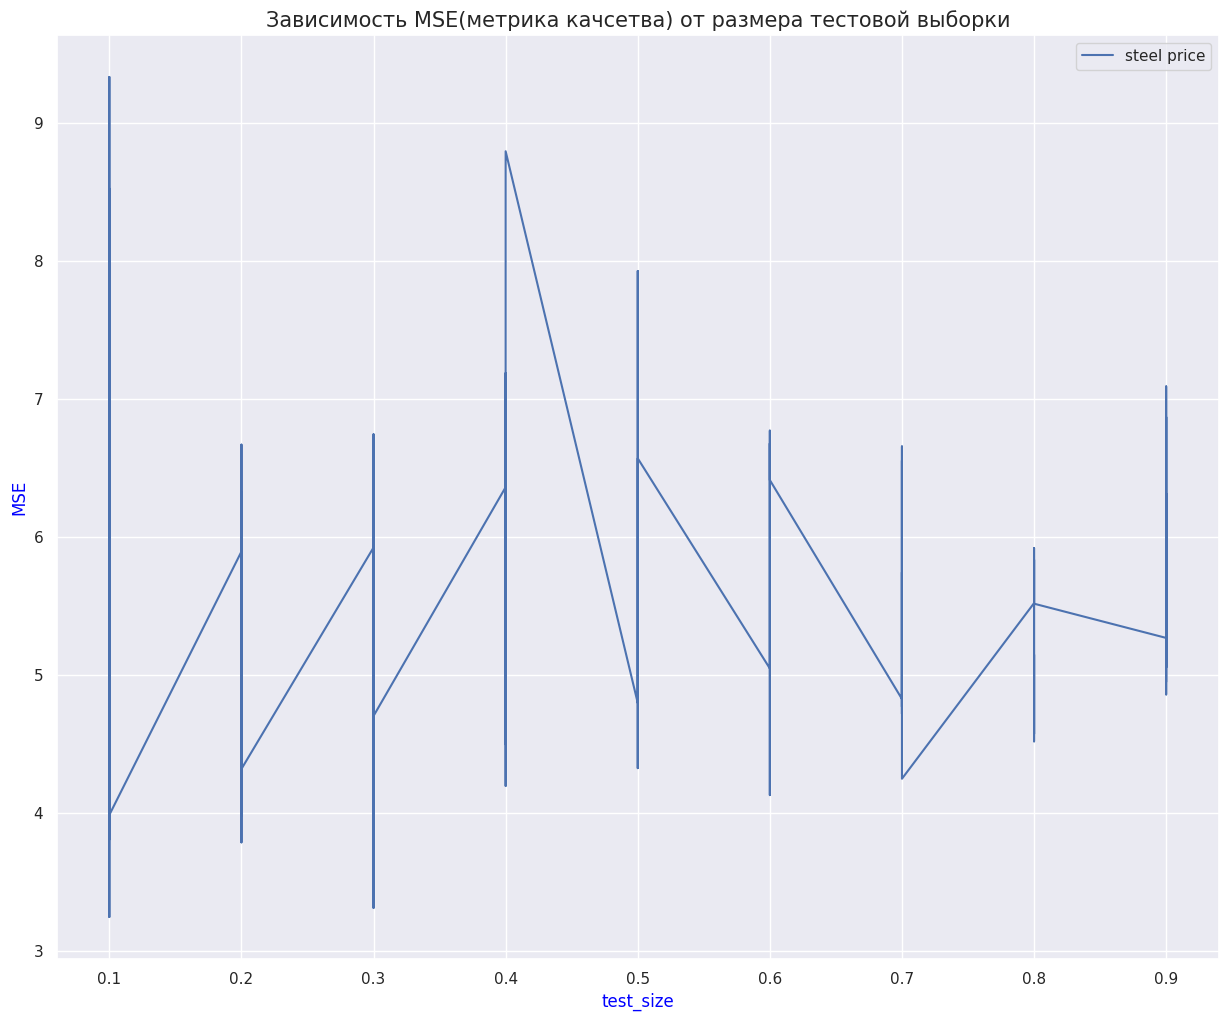

In [139]:
x = list_test_size
y = list_MSE
plt.plot(x, y, label='steel price')
plt.title('Зависимость MSE(метрика качсетва) от размера тестовой выборки', fontsize=15)
plt.xlabel('test_size', fontsize=12, color='blue')
plt.ylabel('MSE', fontsize=12, color='blue')
plt.legend()
plt.grid(True)

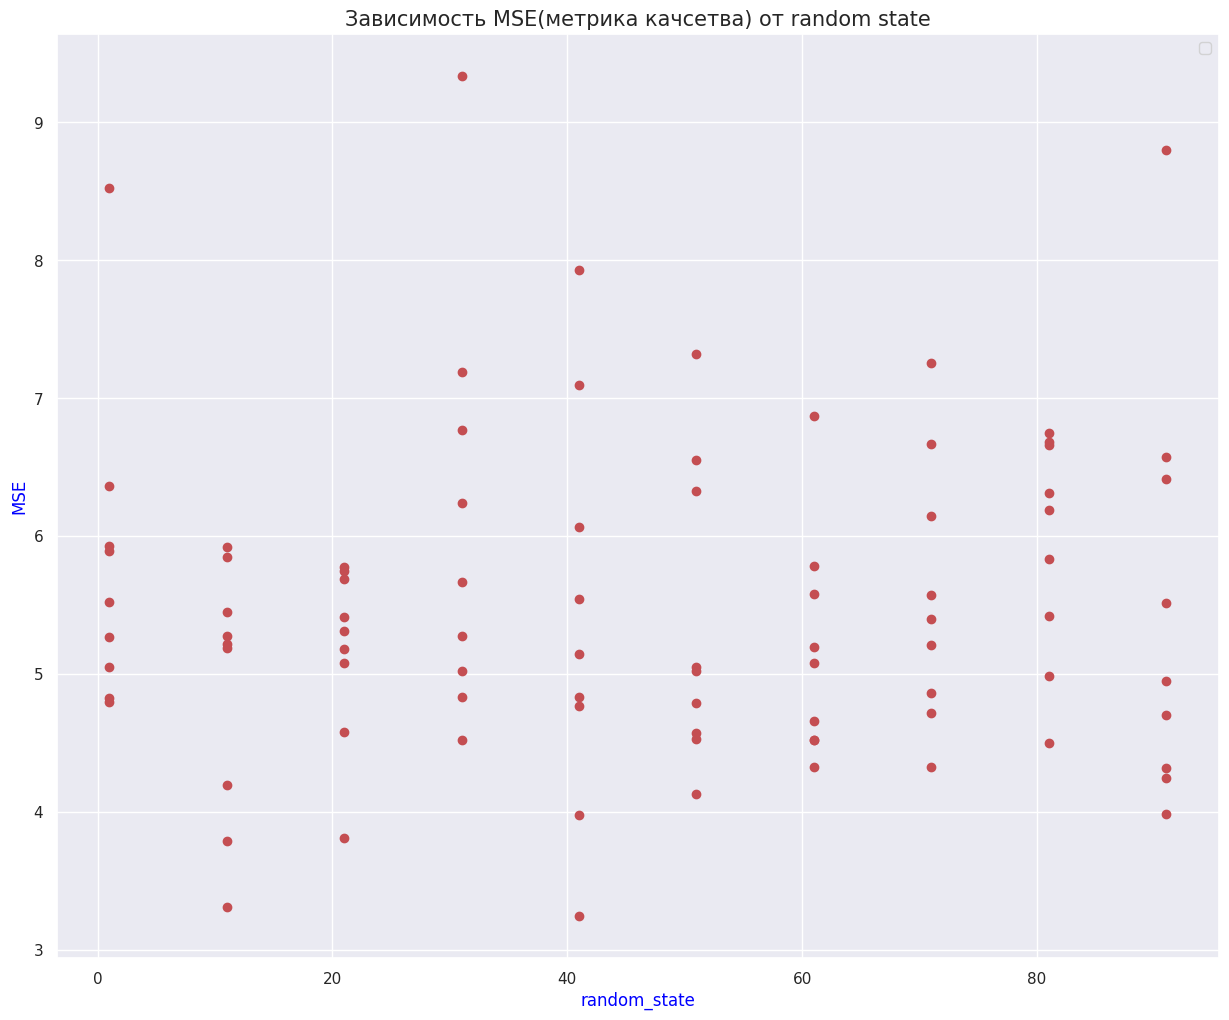

In [140]:
x = list_random
y = list_MSE
plt.plot(x, y, 'ro')
plt.title('Зависимость MSE(метрика качсетва) от random state', fontsize=15)
plt.xlabel('random_state', fontsize=12, color='blue')
plt.ylabel('MSE', fontsize=12, color='blue')
plt.legend()
plt.grid(True)

**Вывод**
Лучший показатель тестовой выборки 30 процентов, а рандомный шаг - 11.

### Проверка модели LinearRegression()

In [141]:
line_reg = LinearRegression() # создаем объект класса
line_reg.fit(X_train, y_train) # обучаем модель

LinearRegression()

In [142]:
y_pred = line_reg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MSE

12.491413983454693

Как видим, метрика MSЕ также ниже, чем полученная путем усреднения, что также говорит нам об адекватности и эффективности данной модели

Попробуем поизменять размеры тестовой и тренировочой выборок при этом изменяя random_state и построим наглядные графики

In [143]:
list_test_size = []
list_MSE = []
list_random = []

for i in range(1, 10):
  for j in range(1, 100, 10):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ["SMILES", "Solubility"],axis=1), data["Solubility"], test_size=i/10, random_state=j)
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    # r2_score = r2_score(y_test, model.predict(X_test))
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    print('test_size', i/10, 'MSE', MSE, 'random state -', j)
    list_test_size.append(i/10)
    list_MSE.append(MSE)
    list_random.append(j)

test_size 0.1 MSE 9.153896451743686 random state - 1
test_size 0.1 MSE 4.10081475330917 random state - 11
test_size 0.1 MSE 4.257181084929068 random state - 21
test_size 0.1 MSE 7.235782538825919 random state - 31
test_size 0.1 MSE 3.574355757144545 random state - 41
test_size 0.1 MSE 7.084285034517641 random state - 51
test_size 0.1 MSE 2.9246851676537515 random state - 61
test_size 0.1 MSE 7.471618094887823 random state - 71
test_size 0.1 MSE 6.137303526380395 random state - 81
test_size 0.1 MSE 4.442586069369216 random state - 91
test_size 0.2 MSE 5.236176789275006 random state - 1
test_size 0.2 MSE 3.153793540988392 random state - 11
test_size 0.2 MSE 4.3668180572016935 random state - 21
test_size 0.2 MSE 6.148892866983849 random state - 31
test_size 0.2 MSE 3.7514090289436854 random state - 41
test_size 0.2 MSE 5.939134689302156 random state - 51
test_size 0.2 MSE 4.851795913298814 random state - 61
test_size 0.2 MSE 5.477261145881759 random state - 71
test_size 0.2 MSE 6.90049896

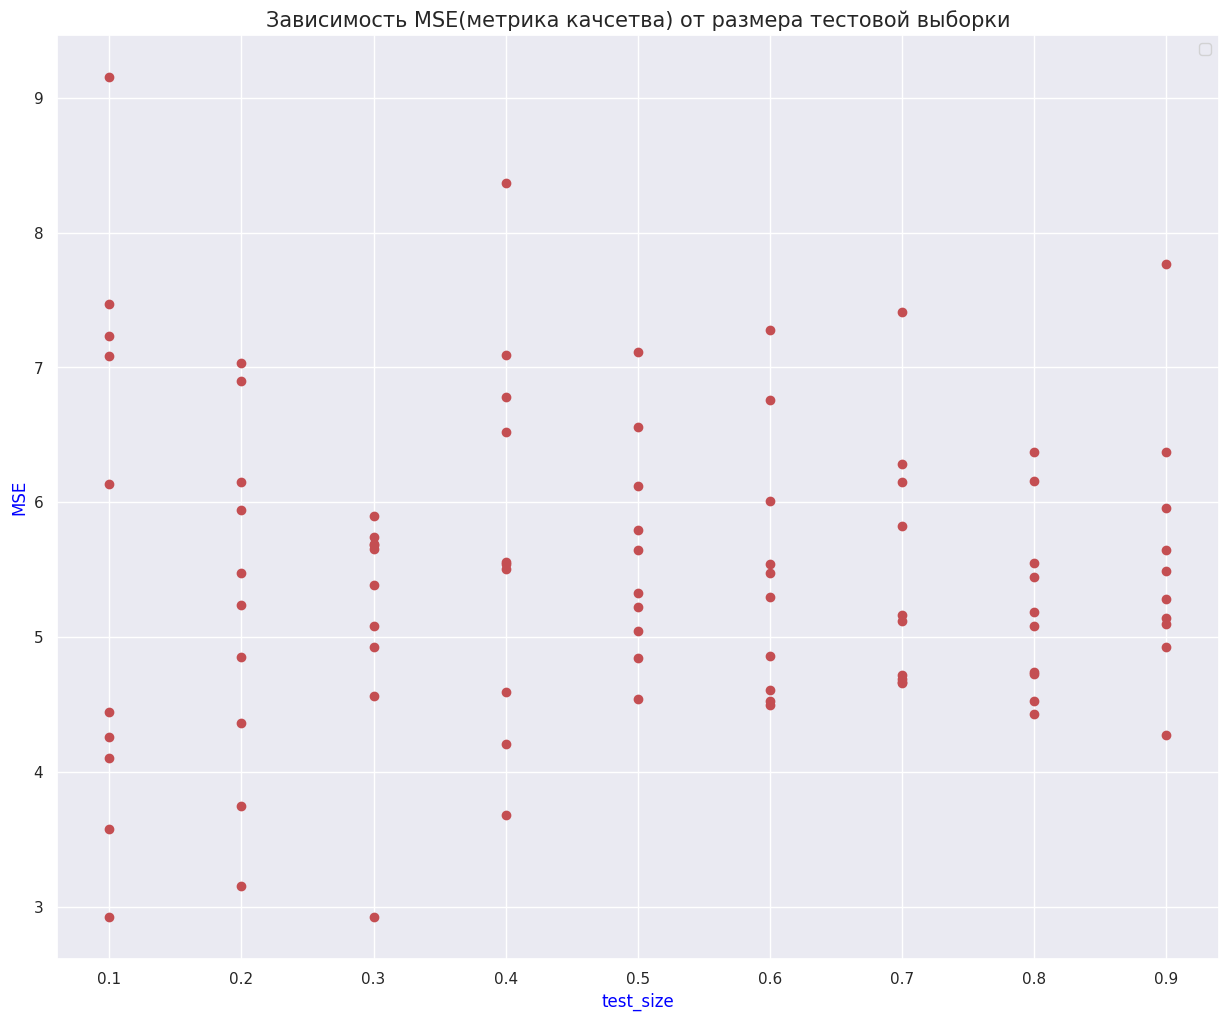

In [160]:
x = list_test_size
y = list_MSE
plt.plot(x, y, 'ro')
plt.title('Зависимость MSE(метрика качсетва) от размера тестовой выборки', fontsize=15)
plt.xlabel('test_size', fontsize=12, color='blue')
plt.ylabel('MSE', fontsize=12, color='blue')
plt.legend()
plt.grid(True)

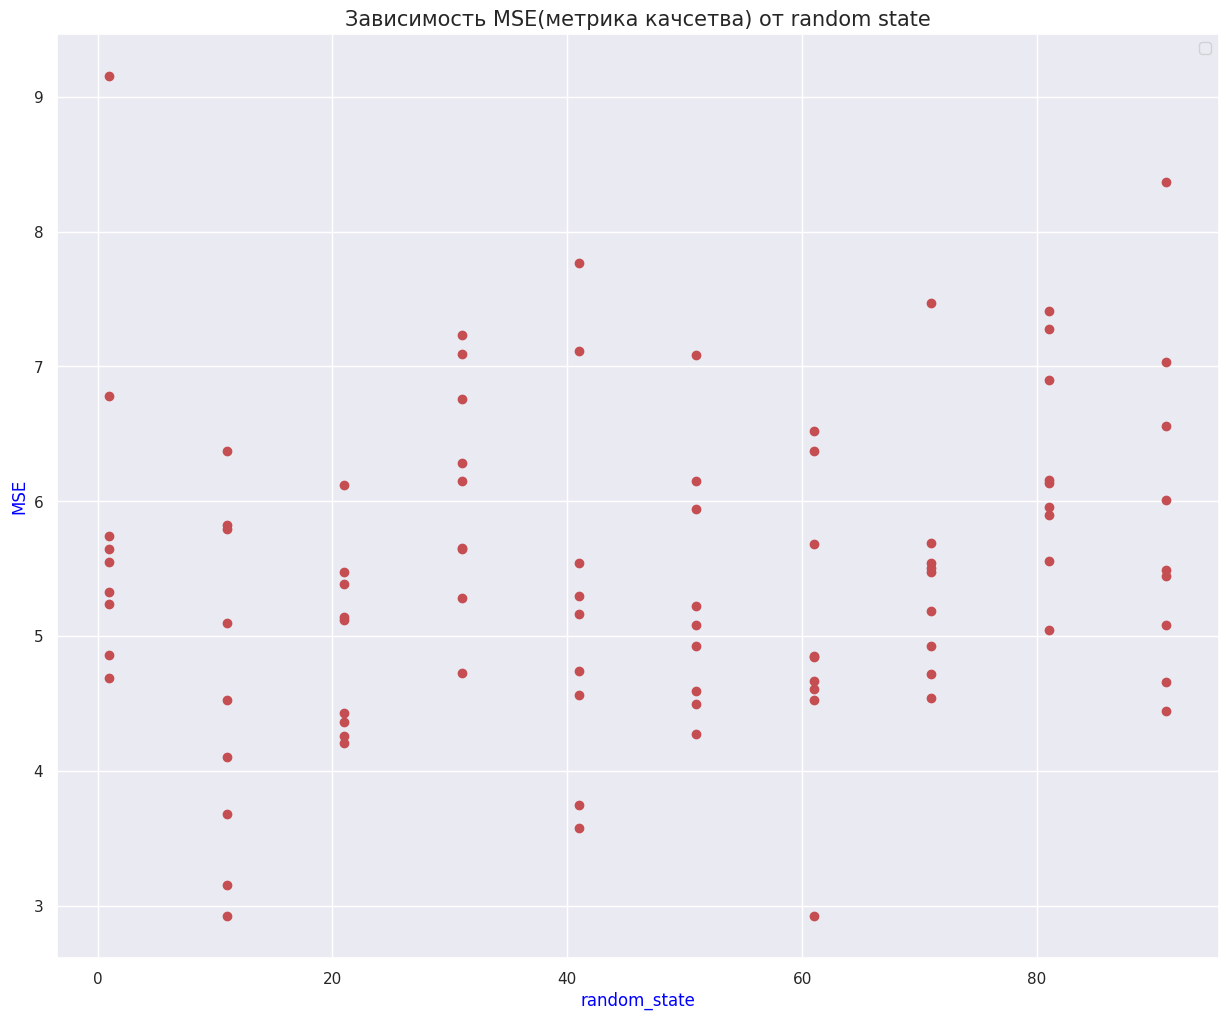

In [145]:
x = list_random
y = list_MSE
plt.plot(x, y, 'ro')
plt.title('Зависимость MSE(метрика качсетва) от random state', fontsize=15)
plt.xlabel('random_state', fontsize=12, color='blue')
plt.ylabel('MSE', fontsize=12, color='blue')
plt.legend()
plt.grid(True)

В данном случае оптимальными оказались размер тестовой выбоки - 10 или 30 процентов, а рандомный шаг - 11.

**Вывод 2**
*Модель DecisionTreeRegressor() для данного датасета является эффективной.*

### Построение модели shap.TreeExplainer(model)
Интерпретация модели Shap
Данная модель используется для интерпретации важностей показателей

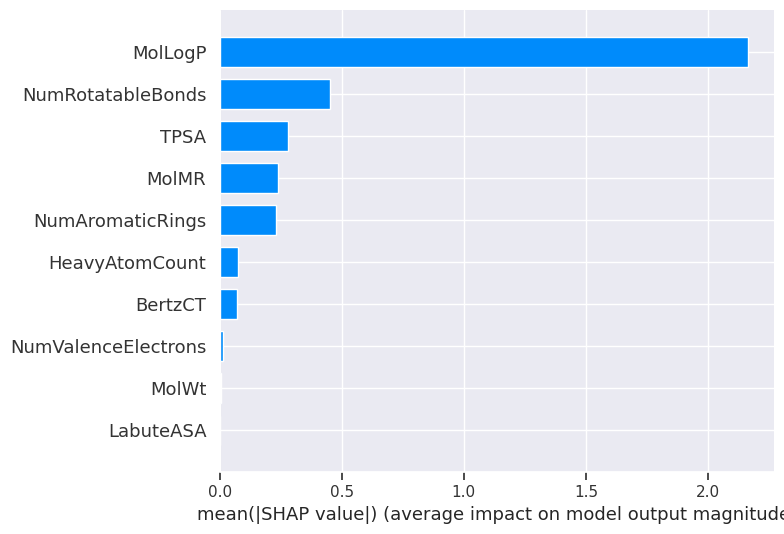

In [146]:

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type='bar')

**Вывод 3**
*Данный график позволяет сделать вывод о том, что показатель MolLogP является наиболее значимым в данном датасете*

### Углубленная работа с решающим деревом

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import numpy as np

In [148]:
data.head()

,SMILES,Solubility,MolLogP,MolMR,HeavyAtomCount,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,LabuteASA,BertzCT,MolWt
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,8.11610,200.710600,53.0,10.0,264.0,6.0,120.72,323.755434,1964.648666,756.226
12,Cc1ccc(O)c(C)c1.Cc2ccc(C)c(O)c2.Cc3cc(C)cc(O)c...,-1.980310,12.05424,225.484800,54.0,0.0,288.0,6.0,121.38,322.890738,1804.418547,733.002
42,[Na+].[Na+].[Na+].[Na+].[Na+].[O-][S](=O)(=O)O...,-0.410898,-14.30130,1544.453427,69.0,15.0,340.0,5.0,433.56,507.575472,3615.453397,1136.328
49,[Na+].[Na+].CCCCCCCCCCCCNc1nc(Cl)nc(Nc2ccc3c(O...,-9.957632,4.10720,211.228600,58.0,20.0,296.0,5.0,246.80,386.497451,2411.468973,868.350
64,CCCCCCCCCCCCCCCCCC(=O)OCC(COC(=O)CCCCCCCCCCCCC...,-5.473001,18.76910,270.436000,63.0,53.0,374.0,0.0,78.90,393.001211,885.583227,891.501


In [149]:
# отделяем признаки, по которым будем обучать модель, игнорируем коррелирующие показатели
features = data[['MolLogP', 'MolMR', 'NumRotatableBonds', 'NumValenceElectrons', 'NumAromaticRings', 'TPSA', 'BertzCT', 'MolWt']].copy()

features.head()

,MolLogP,MolMR,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,TPSA,BertzCT,MolWt
3,8.11610,200.710600,10.0,264.0,6.0,120.72,1964.648666,756.226
12,12.05424,225.484800,0.0,288.0,6.0,121.38,1804.418547,733.002
42,-14.30130,1544.453427,15.0,340.0,5.0,433.56,3615.453397,1136.328
49,4.10720,211.228600,20.0,296.0,5.0,246.80,2411.468973,868.350
64,18.76910,270.436000,53.0,374.0,0.0,78.90,885.583227,891.501


In [150]:
target = data['Solubility'] # отделяем целевой показатель

Обучим очень сложное дерево

In [151]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=11) # ставим оптимальные показатели рандомного шага и тестовой выборки

In [152]:
model = DecisionTreeRegressor(min_samples_leaf=1, random_state=1)

model.fit(features_train, target_train)
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print(f'Качество на обучающей выборке: {mean_absolute_error(pred_train, target_train)}')
print(f'Качество на валидационной выборке: {mean_absolute_error(pred_test, target_test)}')

Качество на обучающей выборке: 0.0002564102564102566
Качество на валидационной выборке: 1.473574649855244


In [153]:
model.get_depth()

15

Понаблюдаем как меняются ошибки в зависимости от сложности алгоритма

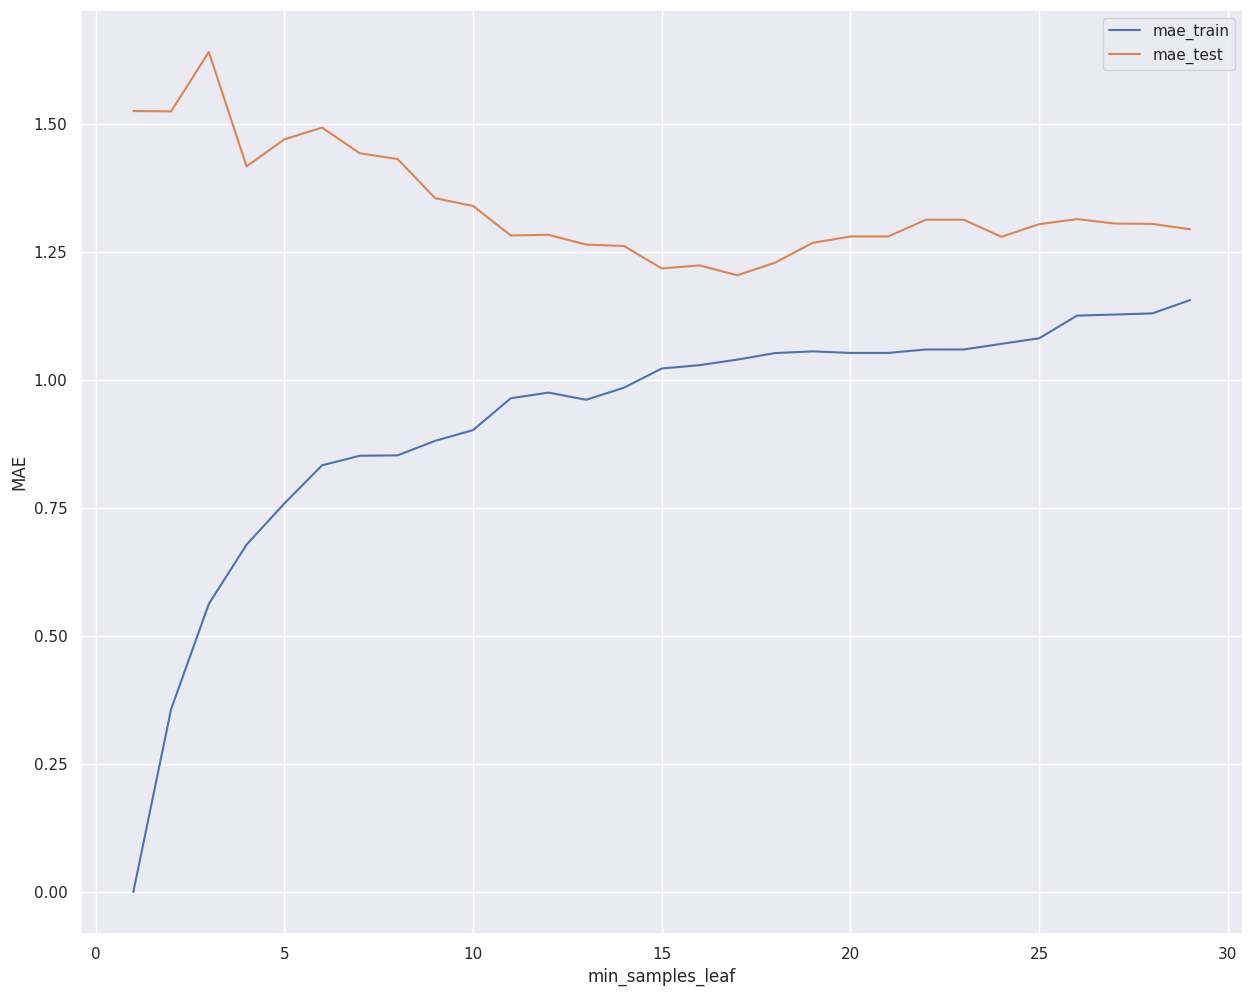

In [154]:
res = []
for param in range(1, 30, 1):
    model = DecisionTreeRegressor(min_samples_leaf=param, random_state=11)

    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    res.append([param, mean_absolute_error(pred_train, target_train), mean_absolute_error(pred_test, target_test)])

res_pd = pd.DataFrame(res, columns=['min_samples_leaf', 'mae_train', 'mae_test'])

res_pd.set_index('min_samples_leaf')['mae_train'].plot(label='mae_train')
res_pd.set_index('min_samples_leaf')['mae_test'].plot(label='mae_test')
plt.legend()
plt.ylabel('MAE');

**Вывод**
Чем сложнее модель, тем выше качество на обучающих данных

In [155]:
res_pd[res_pd['mae_test'] == res_pd['mae_test'].min()]

,min_samples_leaf,mae_train,mae_test
16,17,1.039374,1.203969


### Случайный лес RandomForestRegressor

In [156]:
from sklearn.ensemble import RandomForestRegressor

Увеличим количество деревьев

In [157]:
model = RandomForestRegressor(n_estimators=5, min_samples_leaf=2, random_state=7)

model.fit(features_train, target_train)
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print(f'Ошибка на обучающей выборке: {mean_absolute_error(pred_train, target_train)}')
print(f'Ошибка на валидационной выборке: {mean_absolute_error(pred_test, target_test)}')

Ошибка на обучающей выборке: 0.6361510523182947
Ошибка на валидационной выборке: 1.2640786974267557


Обучим много деревьев

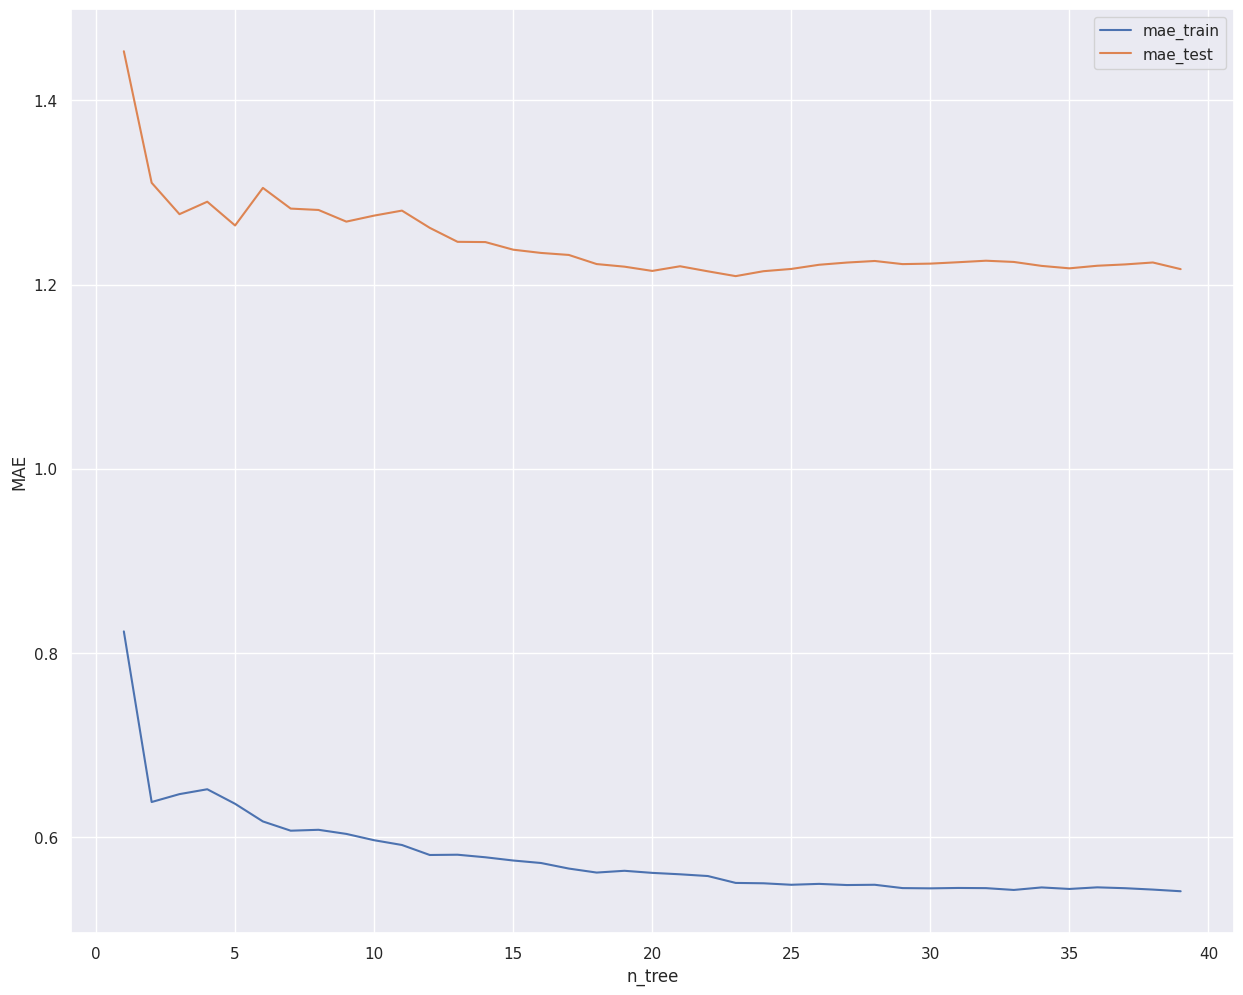

In [158]:
res = []
for n_tree in range(1, 40):
    model = RandomForestRegressor(n_estimators=n_tree, min_samples_leaf=2, random_state=7)

    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    res.append([n_tree, mean_absolute_error(pred_train, target_train), mean_absolute_error(pred_test, target_test)])

res_pd = pd.DataFrame(res, columns=['n_tree', 'mae_train', 'mae_test'])

res_pd.set_index('n_tree')['mae_train'].plot(label='mae_train')
res_pd.set_index('n_tree')['mae_test'].plot(label='mae_test')
plt.legend()
plt.ylabel('MAE');

**Вывод**
Нет смысла строить более 23 деревьев. Показатель MAE стабилизируется.

In [159]:
res_pd[res_pd['mae_test'] == res_pd['mae_test'].min()]

,n_tree,mae_train,mae_test
22,23,0.550237,1.209092


# Общий вывод
Оптимальные показатели MAE были достигнуты с помощью асамблирования решающих деревьев. Оптимальное количество деревьев составляет 23.
Однако все остальные линейные модели оказались адекватными для данного датасета